In [403]:
import sympy as sym
from sympy.polys import subresultants_qq_zz

sym.init_printing()

In [404]:
assert sym.__version__ == '1.1.1'

In [405]:
import imp
bezout = imp.load_source('bezout', '../src/cayley_bezout.py')

The Bezout matrix is a special square matrix associated with two polynomials, introduced by Sylvester (1853) and Cayley (1857) and named after Étienne Bézout. Bézoutian may also refer to the determinant of this matrix, which is equal to the resultant of the two polynomials.. The entries of Bezout matrix
are bilinear functions of coefficients of the given polynomials. The Bezout formulation has gone over
different generalizations. The most common one is the Cayley that is used after for the Dixon 
formulation as well. Caley's paper is in French thus I can to retrive the original formulation. But from here
I am considering this formulation.

% ** Hereafter, we suppose that $n =$ deg$(p)$ $\geq$  $m = $ deg$(q)$. **

$$\left|\begin{matrix}
p(x) & q(x)\cr
p(a)& q(a)
\end{matrix}%
\right|= \Delta(x, a)$$

$\Delta(x, a)$ is the determinant of the matrix.

We have the polynomial:

$$ \delta(x, a) = \frac{\Delta(x,a)}{x-a}$$

The Bezout matrix is highly related to the Sylvester matrix and the great-
est common divisor of polynomials. Unlike in Sylvester's formulation, where the resultant of $p$ and $q$ is the determinant of an $(m + n) \times (m + n)$ matrix, in the Cayley formulation, the resultant is obtained
as the determinant of a $n \times n$ matrix.

In [406]:
b_3, b_2, b_1, b_0 = sym.symbols("b_3, b_2, b_1, b_0")
x = sym.symbols('x')

In [407]:
b = sym.IndexedBase("b")

In [408]:
p = sym.lambdify(x, b_2 * x ** 2 + b_1 * x + b_0)
q = sym.lambdify(x, sym.diff(p(x), x))

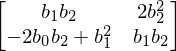

In [411]:
bezout.cayley_bezout_matrix(p, q, x)

Numerical Example One
---------------------

In [413]:
f = sym.lambdify(x, x ** 2 - 5 * x + 6)
g = sym.lambdify(x, x ** 2 - 3 * x + 2)

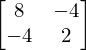

In [414]:
subresultants_qq_zz.bezout(f(x), g(x), x)

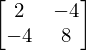

In [415]:
subresultants_qq_zz.bezout(f(x), g(x), x, method='prs')

In [416]:
bezout.cayley_bezout_matrix(f, g, x).det()

Numerical Example Two
---------------------

In [417]:
z = sym.lambdify(x, x ** 2 - 7 * x + 12)
h = sym.lambdify(x, x ** 2 - x)

In [418]:
bezout.cayley_bezout_matrix(z, h, x).det()

Numerical Example Three
-----------------------

In [419]:
y = sym.symbols('y')

In [420]:
f = sym.lambdify(y, x ** 2 + x * y + 2 * x + y -1)
g = sym.lambdify(y, x ** 2 + 3 * x - y ** 2 + 2 * y - 1)
f(x), g(x)

In [421]:
bezout.cayley_bezout_matrix(f, g, y).det().factor()

Numerical Example Four
-----------------------

In [422]:
p = sym.lambdify(x, x**3 +1)
q = sym.lambdify(x, x + 1)

In [423]:
bezout.cayley_bezout_matrix(p, q, x).det()

Dixon's Resultant
-----------------

Dixon (1908) showed how to extend this formulation to $n + 1$ polynomials in $n$ variables.

In a similar manner but this time,

$$\left|\begin{matrix}
p(x, y) & q(x, y) & h(x, y) \cr
p(a, y) & q(a, y) & h(b, y) \cr
p(a, b) & q(a, b) & h(a, b)
\end{matrix}%
\right|= \Delta(x, y, \alpha, \beta)$$

Thus, we have the polynomial:

$$ \delta(x,y, \alpha, \beta) = \frac{\Delta(x, y, \alpha, \beta)}{(x-\alpha)(y - \beta)}$$

In [424]:
from sympy.polys.monomials import itermonomials
import numpy as np
import functools

**Example of Dixon for n=2, m=3 case.**

In [425]:
a_1, a_2, b_1, b_2, u_1, u_2, u_3 = sym.symbols('a_1, a_2, b_1, b_2, u_1, u_2, u_3')

In [426]:
a, b = sym.symbols('alpha, beta')

In [427]:
p = sym.lambdify((x, y), a_1 * x ** 2 * y ** 2 + a_2 * x ** 2)
q = sym.lambdify((x, y), b_1 * x ** 2 * y ** 2 + b_2 * y ** 2)
h = sym.lambdify((x, y), u_1 * x + u_2 * y + u_3)

In [428]:
def dixon_polynomial(p, q, h, x, y):
    """
    Returns the Dixon polynomial, \delta(x, y, \alpha, \beta).
    """
    a, b = sym.symbols('alpha, beta')
    
    matrix = sym.Matrix([[p(x, y), q(x, y), h(x, y)], 
                         [p(a, y), q(a, y), h(a, y)],
                         [p(a, b), q(a, b), h(a, b)]])
    return sym.Poly((matrix.det() / ((x - a) * (y - b))).factor(), a, b)

In [429]:
def get_coeff_of_alpha(polynomial):
    """
    Returns the coefficients of terms x, y in Dixon's polynomial
    when viewed as a polynomial of \alpha.
    """
    coeffs = []
    for a_p, b_p in polynomial.monoms():
        mono = a ** (a_p) * b ** (b_p)
        coeffs.append(polynomial.coeff_monomial(mono))
        
    return coeffs

In [430]:
def construct_dixon_matrix(coeffs, x, y, size):
    """
    Construct the Dixon matrix from the coefficients of polynomial \alpha. Each coefficient is
    viewed as a polynomial of x and y.
    """
    
    mononomials = list(itermonomials([x, y], 4))
    array = np.array([[sym.Poly(c, x, y).coeff_monomial(m) for m in mononomials] for c in coeffs])
    
    return sym.Matrix(np.delete(array, np.nonzero((array==0).sum(axis=0) == size), axis=1))

In [431]:
def dixon_matrix(p, q, h, x, y):
    """
    Returns the Dixon matrix.
    """
    
    polynomial = dixon_polynomial(p, q, h, x, y)
     
    size = len(polynomial.monoms())
    
    coeffs = get_coeff_of_alpha(polynomial)
    matrix = construct_dixon_matrix(coeffs, x, y, size)
    
    return matrix

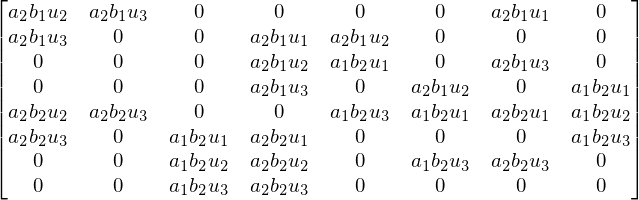

In [432]:
matrix = dixon_matrix(p, q, h, x, y)
matrix

In [433]:
matrix.det().factor()

Dixon's General Case
--------------------

In [434]:
dixon = imp.load_source('dixon', '../src/dixon.py')

In [435]:
polynomials = [p, q, h]

In [436]:
variables = [x, y]

In [437]:
D = dixon.DixonResultant(polynomials, variables)
poly = D.get_dixon_polynomial()

In [439]:
coeff = D.get_coefficients_of_alpha(poly)
size = len(poly.monoms())

In [442]:
D.get_dixon_matrix(poly).det().factor()

Numerical Example 1
--------------------

In [443]:
p = sym.lambdify((x, y), x + y)
q = sym.lambdify((x, y), x ** 2 + y **3)
h = sym.lambdify((x, y), x ** 2 + y)

In [444]:
dixon = dixon.DixonResultant([p, q, h], (x, y))

In [445]:
poly = dixon.get_dixon_polynomial()
poly

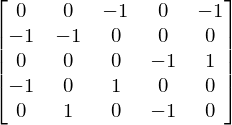

In [447]:
matrix = dixon.get_dixon_matrix(polynomial=poly)
matrix

In [448]:
matrix.det()

Example 2
---------

In [32]:
a, b, c = sym.symbols('a, b, c')

In [33]:
p_1 = sym.lambdify((x, y), a * x ** 2 + b * x * y + (b + c - a) * x + a * y + 3 * (c - 1))
p_2 = sym.lambdify((x, y), 2 * a ** 2 * x ** 2 + 2 * a * b * x * y + a * b * y + b ** 3)
p_3 = sym.lambdify((x, y), 4 * (a - b) * x + c * (a + b) * y + 4 * a * b)
p_3(x, y)

In [34]:
polynomials = [p_1, p_2, p_3]

example_two = DixonResultant(polynomials, [x, y])

In [35]:
poly = example_two.get_dixon_polynomial()

In [36]:
coeff = D.get_coeff_of_alpha(poly)

In [37]:
size = len(poly.monoms())

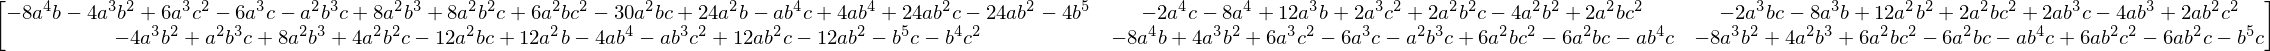

In [38]:
matrix = example_two.dixon_matrix(coeff, size)
matrix